# <span style="font-family: Arial, sans-serif; color:lightskyblue">Binary and Multiclass Modeling</span>
## Part 1: Linear models

<span style="font-family: Arial, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

## Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Fetch blended credit data
url = (
    "https://drive.google.com/file/d/1Is8UZnPRExI-SLJMle8GRbFGpha5IvYZ/view?usp=sharing"
)
url = "https://drive.google.com/uc?id=" + url.split("/")[-2]
dataset = pd.read_csv(url, index_col=False)

features = [
    "revolving_utilization_of_unsecured_lines",
    "account_never_delinq_percent",
    "net_fraction_revolving_burden",
    "num_total_cc_accounts",
    "average_months_in_file",
    "balance",
]

target = "is_bad"

# We assign a label of 2 to the records that almost never had delinquency and are bad
label = "label"
condition = (dataset["account_never_delinq_percent"] > 80) & (dataset[target] == 1)
dataset[label] = np.where(condition, 2, dataset[target])

X, y_binary, y_multi = dataset[features], dataset[target], dataset[label]

ix_train, ix_test = train_test_split(
    X.index, stratify=y_binary, test_size=0.3, random_state=62
)

## Binary

In [29]:
import numpy as np
from sklearn.metrics import roc_auc_score
from fisher_scoring import FisherScoringLogisticRegression
from rich import print as rprint
from rich.table import Table
from rich.console import Console

# Setting up console
console = Console()

# Set print options for numpy
np.set_printoptions(formatter={"float": "{: 0.4f}".format})

# Initialize and fit logistic regression model
logistic_regression = FisherScoringLogisticRegression(
    use_bias=True, information="expected"
)
logistic_regression.fit(X.loc[ix_train], y_binary.loc[ix_train])
logistic_weights = logistic_regression.beta.flatten()

rprint(f"\n\n[bold]Logistic regression[/bold]\n")

# Create the weights table (no surrounding box)
table = Table(show_header=True, header_style="bold cyan", title="Weights for class_1")
table.add_column("[cyan]Feature", justify="right", style="dodger_blue1", no_wrap=True)
table.add_column("[cyan]Weight", justify="right", style="violet")

# Add the weights to the table
for i, weight in enumerate(logistic_weights):
    table.add_row(f"x{i+1}", f"{weight:.4f}")

# Predict probabilities on the test set
predictions = logistic_regression.predict_proba(X.loc[ix_test])[:, 1]

# Compute Gini score
gini_score = 2 * roc_auc_score(y_binary.loc[ix_test], predictions) - 1

# Display the table (weights)
console.print(table)

# Display the Gini score in bold with colors, without surrounding box
console.print(f"\n[cyan]Gini score: [cyan]{gini_score:.2%}\n")

Logistic regression

 Weights for class_1 
┏━━━━━━━━━┳━━━━━━━━━┓
┃ Feature ┃  Weight ┃
┡━━━━━━━━━╇━━━━━━━━━┩
│      x1 │  5.1540 │
│      x2 │  2.8504 │
│      x3 │ -0.0969 │
│      x4 │  0.0238 │
│      x5 │  0.0376 │
│      x6 │ -0.0154 │
│      x7 │  0.0000 │
└─────────┴─────────┘

Gini score: 79.32%

In [30]:
import numpy as np
from fisher_scoring import FisherScoringMultinomialRegression
from sklearn.metrics import roc_auc_score
from rich import print as rprint
from rich.table import Table
from rich.console import Console

# Setting up console
console = Console()

# Initialize and fit multinomial regression model
multinomial_regression = FisherScoringMultinomialRegression(
    use_bias=True, information="expected"
)
multinomial_regression.fit(X.loc[ix_train], y_binary.loc[ix_train])

# Get the multinomial weights
multinomial_weights = np.copy(multinomial_regression.beta)  # type: ignore

# Split the weights by class
weights_by_class = {
    f"class_{i}": multinomial_weights[:, i] for i in range(multinomial_weights.shape[1])
}

# Display the multinomial regression weights by class in a formatted table
rprint(f"\n\n[bold]Multinomial regression[/bold]\n")

for class_name, class_weights in weights_by_class.items():
    # Create a table for each class
    table = Table(show_header=True, header_style="bold cyan", title=f'Weights for {class_name}')
    table.add_column("[cyan]Feature", justify="right", style="dodger_blue1", no_wrap=True)
    table.add_column("[cyan]Weight", justify="right", style="violet")

    # Add the weights for each feature
    for i, weight in enumerate(class_weights):
        table.add_row(f"x{i+1}", f"{weight:.4f}")
    
    # Print the table for the class
    console.print(table)

# Predict probabilities on the test set
predictions = multinomial_regression.predict_proba(X.loc[ix_test])[:, 1]

# Compute the Gini score
gini_score = 2 * roc_auc_score(y_binary.loc[ix_test], predictions) - 1

# Display the Gini score without a surrounding box
console.print(f"\n[cyan]Gini score: [cyan]{gini_score:.2%}\n")

# Display "Multinomial class 1 weights and biases * 2"
console.print("\n\n[bold cyan]Multinomial class 1 weights * 2:[/bold cyan]\n")

# Multiply class 1 weights and biases by 2 and display
class_1_weights = 2 * multinomial_weights.T[1]  # Taking class 1 weights and multiplying by 2
for i, weight in enumerate(class_1_weights):
    console.print(f"[dodger_blue1]Weight {i+1}[/dodger_blue1]: [violet]{weight:.4f}[/violet]")

# Display "Logistic class 1 weights and bias"
console.print("\n\n[bold cyan]Logistic class 1 weights:[/bold cyan]\n")

# Print the logistic weights from previous logistic regression
for i, weight in enumerate(logistic_weights):
    console.print(f"[dodger_blue1]Weight {i+1}[/dodger_blue1]: [violet]{weight:.4f}[/violet]")

Convergence reached after 8 iterations.


Multinomial regression

 Weights for class_0 
┏━━━━━━━━━┳━━━━━━━━━┓
┃ Feature ┃  Weight ┃
┡━━━━━━━━━╇━━━━━━━━━┩
│      x1 │ -2.5770 │
│      x2 │ -1.4252 │
│      x3 │  0.0485 │
│      x4 │ -0.0119 │
│      x5 │ -0.0188 │
│      x6 │  0.0077 │
│      x7 │ -0.0000 │
└─────────┴─────────┘

 Weights for class_1 
┏━━━━━━━━━┳━━━━━━━━━┓
┃ Feature ┃  Weight ┃
┡━━━━━━━━━╇━━━━━━━━━┩
│      x1 │  2.5770 │
│      x2 │  1.4252 │
│      x3 │ -0.0485 │
│      x4 │  0.0119 │
│      x5 │  0.0188 │
│      x6 │ -0.0077 │
│      x7 │  0.0000 │
└─────────┴─────────┘

Gini score: 79.32%

Multinomial class 1 weights * 2:

Weight 1: 5.1540

Weight 2: 2.8504

Weight 3: -0.0969

Weight 4: 0.0238

Weight 5: 0.0376

Weight 6: -0.0154

Weight 7: 0.0000

Logistic class 1 weights:

Weight 1: 5.1540

Weight 2: 2.8504

Weight 3: -0.0969

Weight 4: 0.0238

Weight 5: 0.0376

Weight 6: -0.0154

Weight 7: 0.0000

In [42]:
import pandas as pd
import numpy as np


# Define the highlighting function
def highlight_cells(val):
    color = "#4dabf7" if val == 1 else ""
    return f"background-color: {color}"


# Assuming y is your label array and X is your feature matrix
selected_indices = list(range(998, 1003))

# Sample data for predictions (replace with your actual prediction probabilities)
p1 = logistic_regression.predict_proba(X.loc[selected_indices])[:, 1]
p0 = 1 - p1

# Create DataFrame for labels
df_label = pd.DataFrame(
    {"sample_id": selected_indices, "label": y_binary[selected_indices]}
).reset_index(drop=True)

# Create DataFrame for predictions
df_predictions = pd.DataFrame(
    {"sample_id": selected_indices, "p0": p0, "p1": p1}
).reset_index(drop=True)

# Merge the DataFrames
df_merged = pd.merge(df_label, df_predictions, on="sample_id")

# Apply the highlighting function
styled_df = df_merged.style.map(highlight_cells, subset=["label"])

# Display the styled DataFrame
display(styled_df)

,sample_id,label,p0,p1
0,998,1,0.845133,0.154867
1,999,1,0.363016,0.636984
2,1000,0,0.996337,0.003663
3,1001,0,0.847788,0.152212
4,1002,0,0.988499,0.011501


In [43]:
import pandas as pd
import numpy as np


# Define the highlighting function
def highlight_cells(val):
    color = "#d0bfff" if val == 1 else ""
    return f"background-color: {color}"


def one_hot(y, n_labels=2):
    mat = np.zeros((len(y), n_labels))
    mat[np.arange(len(y)), y] = 1
    return mat.astype(int)


selected_indices = list(range(998, 1003))

p1 = multinomial_regression.predict_proba(X.loc[selected_indices])[:, 1]
p0 = multinomial_regression.predict_proba(X.loc[selected_indices])[:, 0]

labels = pd.DataFrame(one_hot(y_binary[selected_indices]), columns=["label=0", "label=1"])  # type: ignore
df_label = pd.concat(
    [
        pd.Series(selected_indices, name="sample_id"),
        labels,
        pd.Series(p0),
        pd.Series(p1),
    ],
    axis=1,
    ignore_index=True,
)
df_label.columns = ["sample_id", "label=0", "label=1", "p0", "p1"]
styled_df = df_label.style.map(highlight_cells, subset=["label=0", "label=1"])  # type: ignore
display(styled_df)

,sample_id,label=0,label=1,p0,p1
0,998,0,1,0.845133,0.154867
1,999,0,1,0.363016,0.636984
2,1000,1,0,0.996337,0.003663
3,1001,1,0,0.847788,0.152212
4,1002,1,0,0.988499,0.011501


## Multiclass

In [44]:
from fisher_scoring import FisherScoringLogisticRegression
from sklearn.metrics import roc_auc_score

# Prepare to store the results
clfs = {}

# Iterate over classifiers and evaluate them
for i in range(3):
    model = FisherScoringLogisticRegression(
        use_bias=True,
        information="expected",
    )
    # Fit the model
    model.fit(X.loc[ix_train], np.where(y_multi.loc[ix_train] == i, 1, 0))
    clfs[f"Class_{i}"] = model

# Predictions
preds = np.zeros((X.loc[ix_test].shape[0], 3))
class_preds = []
for i in range(3):
    preds[:, i] = clfs[f"Class_{i}"].predict_proba(X.loc[ix_test])[:, 1]
    class_preds = np.argmax(preds, axis=1)
    gini_score = (
        2 * roc_auc_score(np.where(y_multi.loc[ix_test] == i, 1, 0), preds[:, i]) - 1
    )
    print(f"Gini score for class {i}: {gini_score:.2%}")

Gini score for class 0: 79.32%
Gini score for class 1: 95.32%
Gini score for class 2: 66.76%


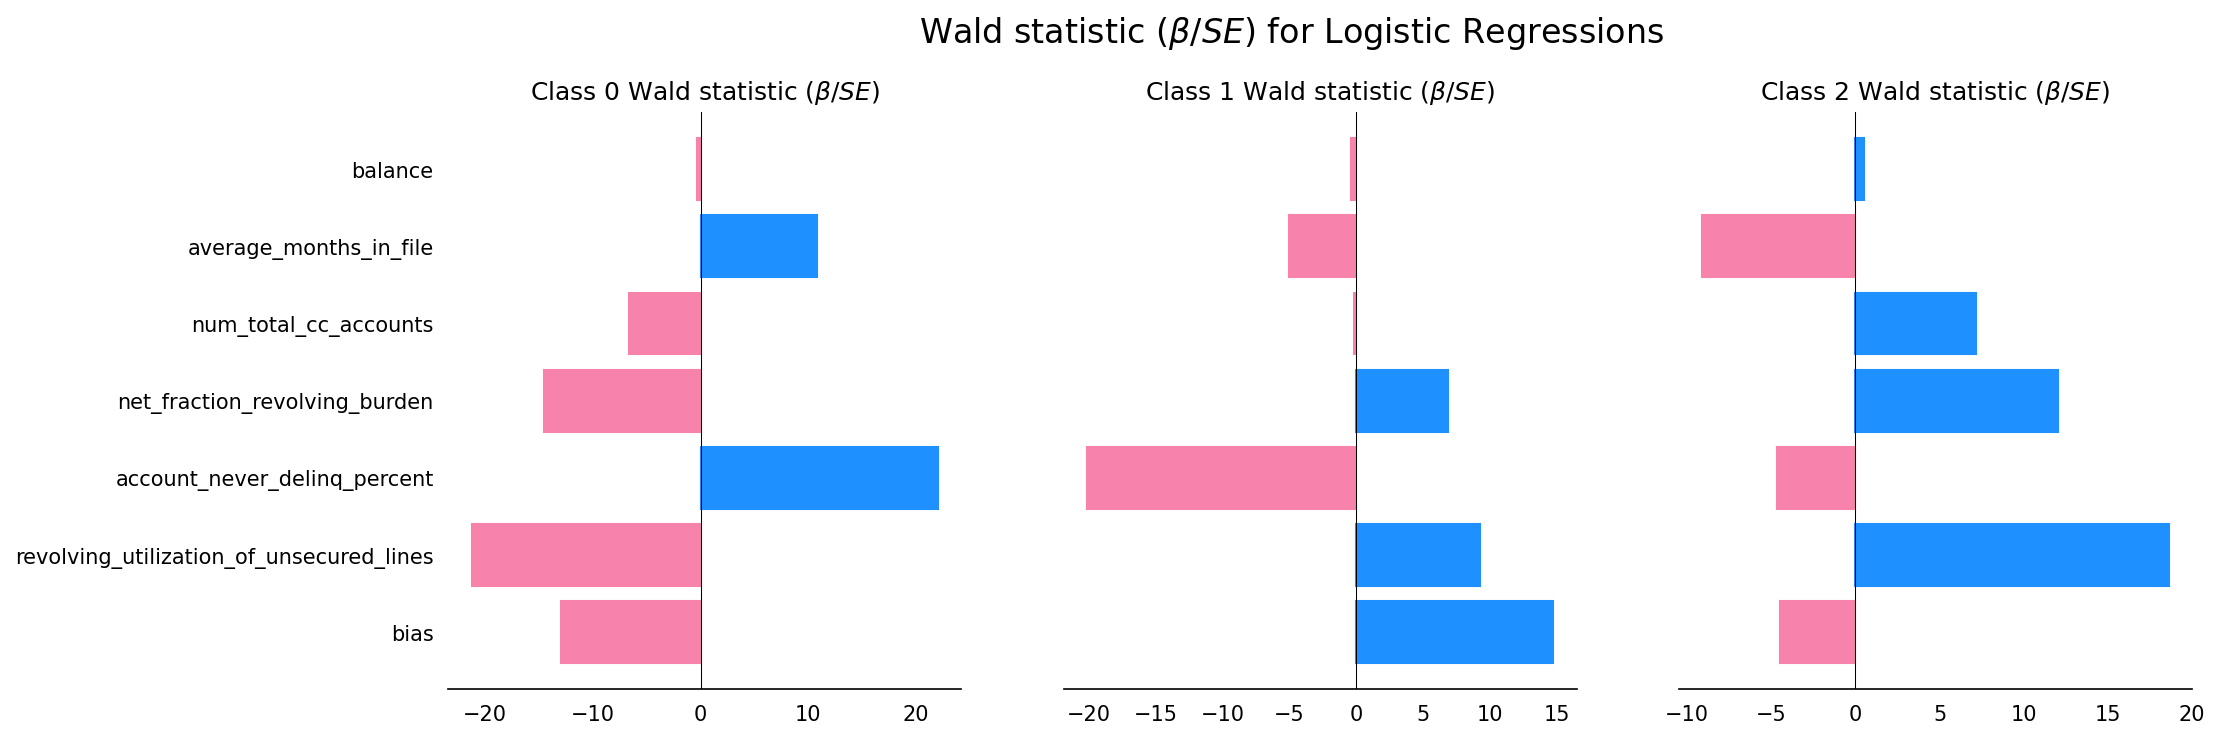

In [45]:
from matplotlib import pyplot as plt

features_ = ["bias"] + features

fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=150, sharey=True)

fig.suptitle(
    "Wald statistic ($\\beta / SE$) for Logistic Regressions", fontsize=16, y=1.01
)
for i, clf in enumerate(clfs):
    coefficients = clfs[f"Class_{i}"].summary()["betas"]
    std_err = clfs[f"Class_{i}"].summary()["standard_errors"]
    coefficients = coefficients / std_err
    ax[i].barh(features_, coefficients)
    ax[i].set_title(f"Class {i} Wald statistic ($\\beta / SE$)")
    for j, coef in enumerate(coefficients):
        if coef > 0:
            ax[i].get_children()[j].set_color("dodgerblue")
        else:
            ax[i].get_children()[j].set_color("#f783ac")
    ax[i].axvline(0, color="black", linewidth=0.5)
    ax[i].tick_params(width=0)
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["left"].set_visible(False)
plt.show()

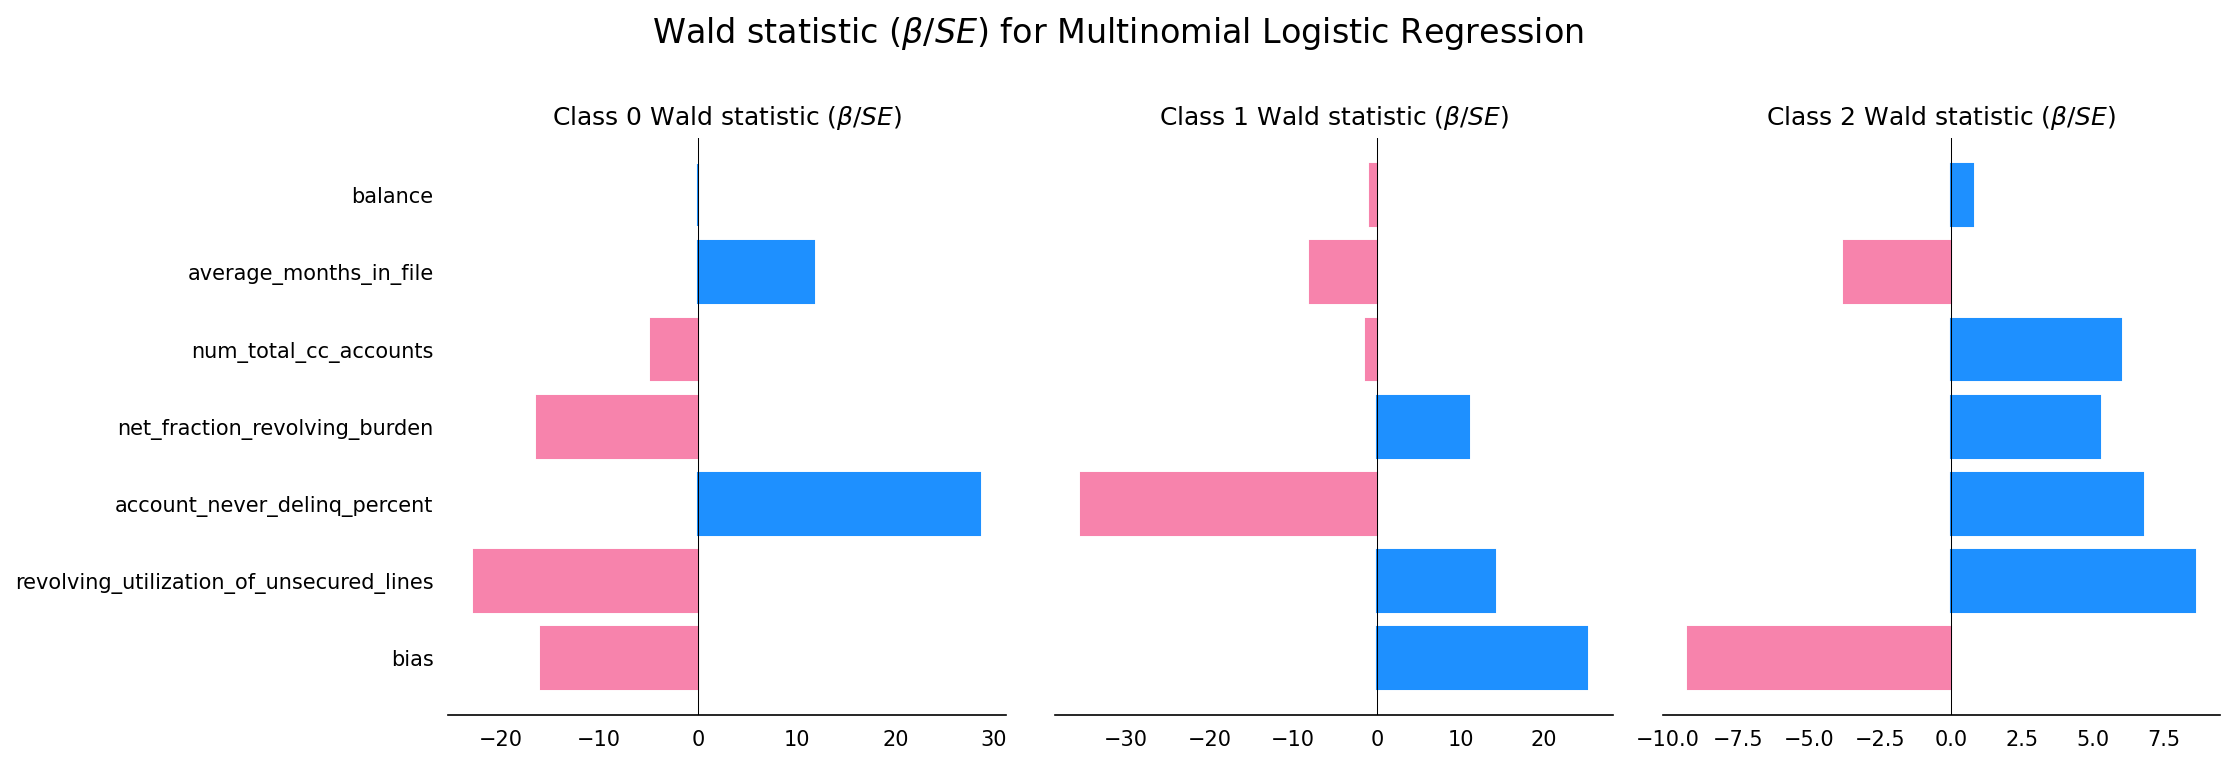

In [46]:
from matplotlib import pyplot as plt
from fisher_scoring import FisherScoringMultinomialRegression

# Initialize the multinomial regression model
multinomial_regression = FisherScoringMultinomialRegression(
    use_bias=True, information="expected"
)
multinomial_regression.fit(X.loc[ix_train], y_multi.loc[ix_train])
num_classes = len(multinomial_regression.beta[0])

fig, ax = plt.subplots(1, num_classes, figsize=(15, 5), dpi=150, sharey=True)
fig.suptitle(
    "Wald statistic ($\\beta / SE$) for Multinomial Logistic Regression",
    fontsize=16,
    y=1.01,
)

# Loop through each class and plot the Wald statistics
for i in range(num_classes):
    # Get the summary for the current class
    summary = multinomial_regression.summary(class_idx=i)
    coefficients = summary["betas"]
    std_err = summary["standard_errors"]
    wald_stat = coefficients / std_err
    ax[i].barh(features_, wald_stat)
    ax[i].set_title(f"Class {i} Wald statistic ($\\beta / SE$)")
    for j, coef in enumerate(wald_stat):
        if coef > 0:
            ax[i].get_children()[j].set_color("dodgerblue")
        else:
            ax[i].get_children()[j].set_color("#f783ac")
    ax[i].axvline(0, color="black", linewidth=0.5)
    ax[i].tick_params(width=0)
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["left"].set_visible(False)
plt.tight_layout()
plt.show()

## Test of coefficients

Here we are comparing the coefficients from the binary logistic regression model with the coefficients from the multiclass logistic regression model. The test is based on the following hypothesis:

$\beta_{1,1} = \beta_{1,2} \quad \text{vs.} \quad H_1: \beta_{1,1} \neq \beta_{1,2}$

where $\beta_{1,1}$ and $\beta_{1,2}$ are the coefficients of the first feature in the binary and multiclass logistic regression models, respectively. The test statistic is given by:

$t = \frac{\beta_{1,1} - \beta_{1,2}}{\sqrt{SE_{1,1}^2 + SE_{1,2}^2}}$

where $SE_{1,1}$ and $SE_{1,2}$ are the standard errors of the coefficients of the first feature in the binary and multiclass logistic regression models, respectively. The test statistic follows a standard normal distribution under the null hypothesis.

[Discussion](https://stats.stackexchange.com/questions/93540/testing-equality-of-coefficients-from-two-different-regressions)

References
---
Clogg, C. C., Petkova, E., & Haritou, A. (1995). Statistical methods for comparing regression coefficients between models. American Journal of Sociology, 100(5), 1261-1293.

Paternoster, R., Brame, R., Mazerolle, P., & Piquero, A. (1998). Using the correct statistical test for equality of regression coefficients. Criminology, 36(4), 859-866.

In [47]:
from scipy import stats
import numpy as np

logistic_class_0_beta = clfs["Class_0"].summary()["betas"]
logistic_class_0_se = clfs["Class_0"].summary()["standard_errors"]

multi_class_0_beta = multinomial_regression.summary(class_idx=0)["betas"]
multi_class_0_se = multinomial_regression.summary(class_idx=0)["standard_errors"]

print("\nLogistic class 0 beta and standard error:")
print(logistic_class_0_beta)
print(logistic_class_0_se)

print("\nMultinomial class 0 beta and standard error:")
print(multi_class_0_beta)
print(multi_class_0_se)

# Calculate Wald statistics for each coefficient
z_stat = (multi_class_0_beta - logistic_class_0_beta) / np.sqrt(
    multi_class_0_se**2 + logistic_class_0_se**2
)

# Calculate two-tailed p-values for each test
p_value = 2 * (1 - stats.norm.cdf(np.abs(z_stat)))

print("\nWald statistics for the difference in coefficients:")
print(z_stat)

print("\nP-value for the difference in coefficients:")
print(p_value)


Logistic class 0 beta and standard error:
[-5.1540 -2.8504  0.0969 -0.0238 -0.0376  0.0154 -0.0000]
[ 0.3979  0.1340  0.0044  0.0016  0.0057  0.0014  0.0000]

Multinomial class 0 beta and standard error:
[-4.1967 -2.0631  0.0822 -0.0176 -0.0181  0.0114  0.0000]
[ 0.2640  0.0908  0.0029  0.0011  0.0038  0.0010  0.0000]

Wald statistics for the difference in coefficients:
[ 2.0046  4.8638 -2.8043  3.1456  2.8570 -2.3163  0.2730]

P-value for the difference in coefficients:
[ 0.0450  0.0000  0.0050  0.0017  0.0043  0.0205  0.7849]
